# Variational Message Passing

Below is an example of Variational Message Passing usage to approximate variance and mean value of an unknown distribution. In that particular example tested sample is generated by using normal distribution.

## Some Theory
*Original idea by John Winn and Christopher M. Bishop. 2005. Variational Message Passing. J. Mach. Learn. Res. 6 (12/1/2005), 661–694.*

So, Variational Message Passing use the same basic idea as Variational Approximation:

$$
Q(\mathbf{H})=\prod_{i} Q_{i}(\mathbf{H}_{i})
$$

This is idea that we can separate set of variables into smaller disjoint sets. Although in reality, this is almost impossible. But for goals of approximation, this idea helps us get rid of integrals for calculation of conditional variables. This is the only assumption we need to begin our process.

In every iteration, we approximate selected set and fix others set values. After approximation, the set is fixed and we move to the next set. Then process repeat.

$$
\ln Q_i^\*(\mathbf H_i)
= \big\langle \ln p(\mathbf H,\mathbf V) \big\rangle_{Q_{\neg i}}
\;+\; \text{const.}
$$

VMP turns this into local messages on a factor graph: each update only needs expectations from neighboring nodes (expected natural parameters), which makes the algorithm modular and fast.


## Model used in the code

We assume data $(x_1,\dots,x_N)$ with
$
x_n \mid \mu, v \sim \mathcal N(\mu,\, \sigma^2),
$
and independent priors
$
\mu \sim \mathcal N(m_0,\ \beta),
\sigma^2 \sim \mathrm{InvGamma}(a,\ b).
$

We approximate with the mean-field family
$$
Q(\mu)\,Q(v)
= \mathcal N(\mu;\ m,\ \beta) \times \mathrm{InvGamma}(\sigma^2; a, b).
$$

> **Notation.** For the variance node \(v\) we use the **shape–scale** parameterization.
> Useful expectations:
> $
> \mathbb E\!\left[\tfrac{1}{v}\right]=\frac{a}{b},
> \qquad
> \mathbb E[\ln v]=\ln(b)-\psi(a).
> $

---



## Messages and updates (what the code implements)

### 1) Variance $v \to$ data $x_n$
Same for all \(n\):
$
\big\langle \mathbf u_v \big\rangle
=
\begin{bmatrix}
\langle 1/v\rangle\\[2pt]
\langle \ln v\rangle
\end{bmatrix}
=
\begin{bmatrix}
\alpha/\beta\\[2pt]
\ln\beta-\psi(\alpha)
\end{bmatrix}.
$

### 2) Data $x_n \to$ mean $\mu$
Using only $\langle 1/v\rangle$:
$$
m_{x\to v} =
\begin{bmatrix}
\langle 1/v\rangle\,x_i\\[2pt]
-\tfrac12\,\langle 1/v\rangle
\end{bmatrix}.
$$
Summing over \(n\) and adding the Normal prior on $\mu$ gives canonical parameters
$$
\phi_u =
\begin{bmatrix}
\beta\mu\\[2pt]
-\beta/2
\end{bmatrix} +
\sum_{n=1}^N m_{x\to \mu}
$$

$$
\mu=-2 * \phi_u[1]
\qquad
\beta=\phi_u[0] / -2 * \phi_u[1]
$$

### 3) Mean $\mu \to$ data $x_n$
The message needs the moments of $\mu$:
$$
\langle \mu\rangle = m,
\qquad
\langle \mu^2\rangle = m^2 + \beta^{-1}.
$$

### 4) Data $x_n \to$ variance $v$
Per datum (in the $[\ln v,\ 1/v]$ sufficient-stat order):
$$
m_{x\to y} =
\begin{bmatrix}
-\tfrac12\\[4pt]
-\tfrac12\,\mathbb E\!\big[(x_i-\mu)^2\big]
\end{bmatrix},
\qquad
\mathbb E\!\big[(x_i-\mu)^2\big]=(x_i-m)^2+\beta^{-1}.
$$
Summing over $n$ combining with the $\mathrm{InvGamma}(\alpha_0,\beta_0)$ prior yields the closed-form update
$$
\alpha = \alpha_0 + \frac{N}{2},
\qquad
\beta = \beta_0 + \frac{1}{2}\sum_{n=1}^{N}\big((x_n-m)^2+\beta^{-1}\big).
$$

In [9]:
from scipy.stats import norm

real_mean = 12
real_variance = 2

x = norm.rvs(loc=real_mean, scale=real_variance, size=5, random_state=42)   # N(0,1)

In [10]:
from scipy.special import digamma
import numpy as np

x_mean = float(np.mean(x))
x_var  = float(np.var(x, ddof=0))

a = 2.1
b = (a - 1.0) * 1
a0 = a
b0 = b

m = 0
beta = .1

# first cycle and helping functions

print("my init m and beta are " + str((round(m, 4), round(beta, 4))))
print("my init a and b are " + str((round(a, 4), round(b, 4))))
# step 1: creating message from y to x
print("\n-------------------------------step 1--------------------------------------------------")

def inverse_gamma_expectations(local_a, local_b):
    E1_divided_by_v = local_a / local_b
    Elogv = np.log(local_b) - digamma(local_a)
    return np.array([E1_divided_by_v, Elogv])

message_y_to_x = inverse_gamma_expectations(a, b)
print("my message from y to x is " + np.array2string(message_y_to_x, precision=4))

# step 2: creating messages from x to u and recalculate m and beta for normal distribution of mean value
print("\n-------------------------------step 2--------------------------------------------------")
# step 2a: get sum of messages
def get_sum_of_messages_x_to_u(x_local, message_y_to_x_local):
    sum_of_messages_x_to_u_local = np.array([0, 0])
    for each_x_local in x_local:
        A = np.array([[each_x_local, 0.0], [-0.5, 0.0]])
        sum_of_messages_x_to_u_local = sum_of_messages_x_to_u_local + A @ message_y_to_x_local  # matrix multiplication

    return sum_of_messages_x_to_u_local

sum_of_messages_x_to_u = get_sum_of_messages_x_to_u(x, message_y_to_x)

# step 2b: recalculate m and beta
def update_normal_distribution(m_local, beta_local, sum_of_messages_x_to_u_local):
    phi_m = np.array([beta_local*m_local, -beta_local / 2]) + sum_of_messages_x_to_u_local

    beta_local = -2 * phi_m[1]
    m_local = phi_m[0] / (-2 * phi_m[1])

    return m_local, beta_local

m, beta = update_normal_distribution(m, beta, sum_of_messages_x_to_u)
print(f"my new m and beta are ({float(m):.4f}, {float(beta):.4f})")

# step 3: creating message from u to x
print("\n-------------------------------step 3--------------------------------------------------")

message_u_to_x = np.array([m, m**2 + 1 / beta])

print("my message from u to x is " + np.array2string(message_u_to_x, precision=4))

# step 4: sending message from each x to y and updating v
print("\n-------------------------------step 4--------------------------------------------------")
# step 4a: get sum of messages
def get_sum_of_messages_x_to_y(x_local, message_u_to_x_local):
    sum_of_messages_x_to_y_local = np.zeros(2, dtype=float)

    for each_x_local in x_local:
        message_x_to_y_local = np.array([ -1/2,
                                          -(each_x_local**2 - 2 * each_x_local * message_u_to_x_local[0] + message_u_to_x_local[1])/2])
        sum_of_messages_x_to_y_local = sum_of_messages_x_to_y_local + message_x_to_y_local

    return sum_of_messages_x_to_y_local

sum_of_messages_x_to_y = get_sum_of_messages_x_to_y(x, message_u_to_x)
print("my message from x to y is " + np.array2string(sum_of_messages_x_to_y, precision=4))

# step 4b: update a and b from inverse gamma distribution
def update_inverse_gamma_distribution(a_local, b_local, sum_of_messages_x_to_y_local):
    # from Exponential family inverse gamma distribution
    # https://en.wikipedia.org/wiki/Exponential_family

    phi_y = np.array([-a_local-1, -b_local]) + sum_of_messages_x_to_y_local

    a_local = -phi_y[0] - 1
    b_local = -phi_y[1]

    return a_local, b_local

a, b = update_inverse_gamma_distribution(a0, b0, sum_of_messages_x_to_y)
print(f"my new a and b are ({float(a):.4f}, {float(b):.4f})")

my init m and beta are (0, 0.1)
my init a and b are (2.1, 1.1)

-------------------------------step 1--------------------------------------------------
my message from y to x is [ 1.9091 -0.39  ]

-------------------------------step 2--------------------------------------------------
my new m and beta are (12.7841, 9.6455)

-------------------------------step 3--------------------------------------------------
my message from u to x is [ 12.7841 163.5363]

-------------------------------step 4--------------------------------------------------
my message from x to y is [-2.5    -4.3168]
my new a and b are (4.6000, 5.4168)


In [11]:
# run the cycle for 50 times!
history = {"u_mean": [], "u_variance": [], "sn_mean": [], "sn_variance": [], "real_mean": [], "real_variance": []}

from scipy.special import digamma
import numpy as np

x_mean = float(np.mean(x))
x_var  = float(np.var(x, ddof=1))

a = 5
b = 5

m = 0
beta = 5

a0 = a
b0 = b

for it in range(1, 301):
    # step 1: creating message from y to x
    message_y_to_x = inverse_gamma_expectations(a, b)

    # step 2a: get sum of messages  from each x to u
    sum_of_messages_x_to_u = get_sum_of_messages_x_to_u(x, message_y_to_x)

    # step 2b: recalculate m and beta
    m, beta = update_normal_distribution(m, beta, sum_of_messages_x_to_u)

    # step 3: creating message from u to x
    message_u_to_x = np.array([m, m**2 + 1 / beta])

    # step 4a: get sum of messages from each x to y
    sum_of_messages_x_to_y = get_sum_of_messages_x_to_y(x, message_u_to_x)

    # step 4b: update a and b from inverse gamma distribution
    a, b = update_inverse_gamma_distribution(a0, b0, sum_of_messages_x_to_y)

    history["u_mean"].append(m)
    history["u_variance"].append(1/beta)

    history["sn_mean"].append(a)
    history["sn_variance"].append(a/(b**2))

    history["real_mean"].append(x_mean)
    history["real_variance"].append(x_var)



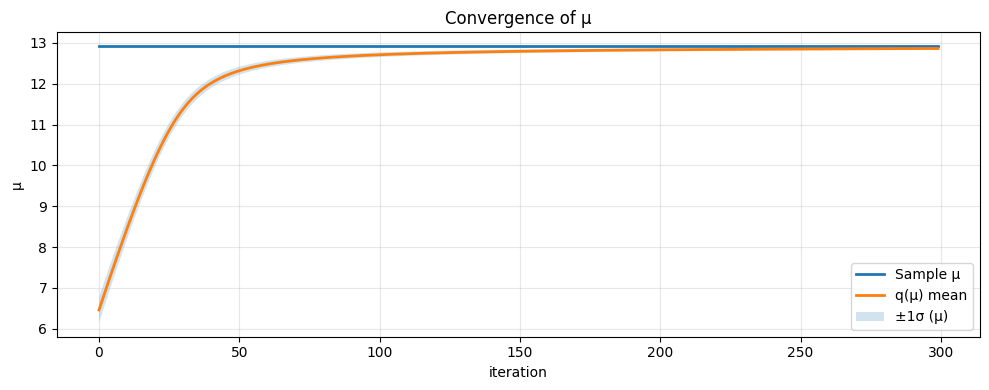

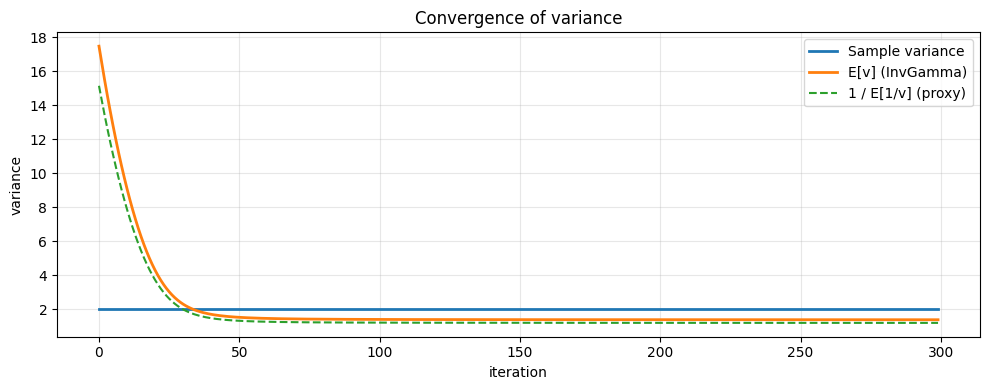

In [12]:
# P.S. plots are generated with help of ChatGPT

import numpy as np
import matplotlib.pyplot as plt

# assume `history` is already filled
u_mean = np.asarray(history["u_mean"], dtype=float)
u_var  = np.asarray(history["u_variance"], dtype=float)  # Var(μ) = 1/β
a_seq  = np.asarray(history["sn_mean"], dtype=float)     # here: shape α_k
var_tau_seq = np.asarray(history["sn_variance"], dtype=float)  # Var(τ) = α / β^2
real_mean = np.asarray(history["real_mean"], dtype=float)
real_var  = np.asarray(history["real_variance"], dtype=float)

iters = np.arange(len(u_mean))

# --- Reconstruct variance-node expectations from (a, Var(τ)) ---
# τ = 1/v ~ Gamma(α, rate=β): Var(τ) = α / β^2  =>  β = sqrt(α / Var(τ))
EPS = 1e-12
beta_seq = np.sqrt(a_seq / np.maximum(var_tau_seq, EPS))     # Inv-Gamma scale parameter b_k
E_tau    = np.sqrt(a_seq * np.maximum(var_tau_seq, EPS))     # E[τ] = α / β = sqrt(α * Var(τ))

# Variance expectation (only defined for α > 1):
E_v = np.where(a_seq > 1.0, beta_seq / (a_seq - 1.0), np.nan)  # E[v] for InvGamma(α, β)

# Also useful proxy: 1 / E[τ] (Jensen-inequality biased, but often plotted)
inv_E_tau = 1.0 / np.maximum(E_tau, EPS)

# --- Plot 1: μ tracking (with ±1σ band from Var(μ)) ---
plt.figure(figsize=(10, 4))
plt.plot(iters, real_mean, label="Sample μ", linewidth=2)
plt.plot(iters, u_mean, label="q(μ) mean", linewidth=2)
# 1-sigma band
u_std = np.sqrt(np.maximum(u_var, 0.0))
plt.fill_between(iters, u_mean - u_std, u_mean + u_std, alpha=0.2, label="±1σ (μ)")

plt.xlabel("iteration")
plt.ylabel("μ")
plt.title("Convergence of μ")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# --- Plot 2: variance tracking ---
plt.figure(figsize=(10, 4))
plt.plot(iters, real_var, label="Sample variance", linewidth=2)
plt.plot(iters, E_v, label="E[v] (InvGamma)", linewidth=2)
plt.plot(iters, inv_E_tau, "--", label="1 / E[1/v] (proxy)", linewidth=1.5)

plt.xlabel("iteration")
plt.ylabel("variance")
plt.title("Convergence of variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


### Results and Conclusion

As a result, approximations of mean distribution value and variance convergent into sample variance and mean. That is because I used simple normal distribution to test the theory. But there is no difference for a method between random values from $N(m,\ \beta)$ and normal distribution with sample mean as a mean and sample variance as variance.

With tuned hyperparameters, values can convergent even faster, but for goal of visualisation, I used parameters specifically to show how method behave through iterations.

I implemented Variational Message Passing (VMP) for a Gaussian likelihood with
an unknown mean and variance, using a Normal factor for the mean and an
Inverse-Gamma factor for the variance. Under the mean-field assumption
$Q(\mu)Q(v)$, each iteration requires only local expectations:

- the mean update uses $ \mathbb{E}[1/v] = \alpha/\beta $;
- the variance update uses the summed expected squared residuals
  $ \sum_n \mathbb{E}[(x_n-\mu)^2] = \sum_n (x_n-m)^2 + N/\beta $.

With sensible priors (weak Normal prior on $\mu$, shape–scale Inv-Gamma for $v$
centered near the data variance) the algorithm converges quickly and stably:
$m$ moves from the prior toward the sample mean, while the posterior over
$v$ tightens around the empirical variance. Using fixed priors $(\alpha_0,\beta_0)$
at every iteration (rather than accumulating $\alpha$) and maintaining
the correct message signs/order $[\ln v,\,1/v]$ prevents numerical issues
(NaNs, negative scales). Optional damping further stabilizes updates on
noisy datasets.

Overall, VMP reproduces the closed-form conjugate updates while exposing
them as modular “messages,” making the approach easy to extend to larger
graphs (e.g., hierarchical means, mixture models).